# IAM Tractometry with [TractSeg](http://yeatmanlab.github.io/pyAFQ/index.html)

This script ustilizes TractSeg to perform tractometry on select IAM subjects. This scripts serves as an investigational tool in determining a DKI post-processing pipeline.

## Load all required modules

Load all required Python modules

In [1]:
import os
import os.path as op
import glob
import tscompatibility as ts
import subprocess
from IPython.display import Image

## Define paths
Define paths to various input/output folders. Input folder needs to be defined as that containing subject folders, while the output directory will contain TractSeg's outputs.

In [2]:
input = '/Users/dataprocessing/Documents/IAM/TractSeg_Subs_BAK'
output = '/Users/dataprocessing/Documents/IAM/TractSeg'
path_mni = '/Users/dataprocessing/Documents/IAM/TractSeg/MNI_FA_template.nii.gz'

## 1. Read Subject Information

Read the content of input directory to form a list of subjects.

In [3]:
subPaths = glob.glob(op.join(input, '*'))

## 2. Process Each Subject

In [6]:
failedRun = []
for i in subPaths:
    subID = op.basename(i)
    
    subOut = op.join(output, subID)
    ts.runtractseg(input=i,
               output=subOut,
               template=path_mni,
               docker=None)
#     try:
#         runtractseg(input=i,
#                    output=subOut)
#     except:
#         failedRun.append(subID)

Processing IAM_1158

----- Files being processed -----
Metric: /Users/dataprocessing/Documents/IAM/TractSeg_Subs_BAK/IAM_1158/metrics/fa.nii
DWI: /Users/dataprocessing/Documents/IAM/TractSeg_Subs_BAK/IAM_1158/dwi_preprocessed.nii
BVEC: /Users/dataprocessing/Documents/IAM/TractSeg_Subs_BAK/IAM_1158/dwi_preprocessed.bvec
BVAL: /Users/dataprocessing/Documents/IAM/TractSeg_Subs_BAK/IAM_1158/dwi_preprocessed.bval
Mask: /Users/dataprocessing/Documents/IAM/TractSeg_Subs_BAK/IAM_1158/brain_mask.nii
---------------------------------

STAGE 1: Image registration into MNI space

Removing NaNs from scalar image
Computing transformation affine matrix
Transform metric into MNI space...
Thresholding scalar image
Transform DWI into MNI space...
Transform brain mask into MNI space...
Rotating BVECs into MNI space...
Copying BVALs...

STAGE 2: Processing with TractSeg

Creating segmentation bundles...
Creating ending segmentation bundles...
Creating TOMs...
Creating TOM tractograms...
Running tracotomet

Transform metric into MNI space...
Thresholding scalar image
Transform DWI into MNI space...
Transform brain mask into MNI space...
Rotating BVECs into MNI space...
Copying BVALs...

STAGE 2: Processing with TractSeg

Creating segmentation bundles...
Creating ending segmentation bundles...
Creating TOMs...
Creating TOM tractograms...
Running tracotometry...


Processing IAM_1162

----- Files being processed -----
Metric: /Users/dataprocessing/Documents/IAM/TractSeg_Subs_BAK/IAM_1162/metrics/fa.nii
DWI: /Users/dataprocessing/Documents/IAM/TractSeg_Subs_BAK/IAM_1162/dwi_preprocessed.nii
BVEC: /Users/dataprocessing/Documents/IAM/TractSeg_Subs_BAK/IAM_1162/dwi_preprocessed.bvec
BVAL: /Users/dataprocessing/Documents/IAM/TractSeg_Subs_BAK/IAM_1162/dwi_preprocessed.bval
Mask: /Users/dataprocessing/Documents/IAM/TractSeg_Subs_BAK/IAM_1162/brain_mask.nii
---------------------------------

STAGE 1: Image registration into MNI space

Removing NaNs from scalar image
Computing transformation affine

In [7]:
print(failedRun)

[]


In [8]:
subList = [op.basename(x) for x in subPaths]
for i in subList:
    print(i)

IAM_1158
IAM_1160
IAM_1156
IAM_1157
IAM_1161
IAM_1159
IAM_1163
IAM_1164
IAM_1165
IAM_1162


## Run group analysis

In [9]:
print('STAGE 3: Group analysis')
print('')
arg = ['plot_tractometry_results']
arg.extend(['-i', '/Users/dataprocessing/Documents/IAM/TractSeg/subjects_FA.txt'])
arg.extend(['-o', '/Users/dataprocessing/Documents/IAM/TractSeg/tractometry_result_FA.png'])
# arg.extend(['--plot3D', 'metric', '--tracking_format', 'trk'])
arg.append('--mc')
print('COMMAND: {}'.format(' '.join(arg)))
completion = subprocess.run(arg)
if completion.returncode != 0:
    raise Exception('Unable to run TractSeg: Group analysis. '
                    'Check above for errors')

STAGE 3: Group analysis

COMMAND: plot_tractometry_results -i /Users/dataprocessing/Documents/IAM/TractSeg/subjects_FA.txt -o /Users/dataprocessing/Documents/IAM/TractSeg/tractometry_result_FA.png --mc


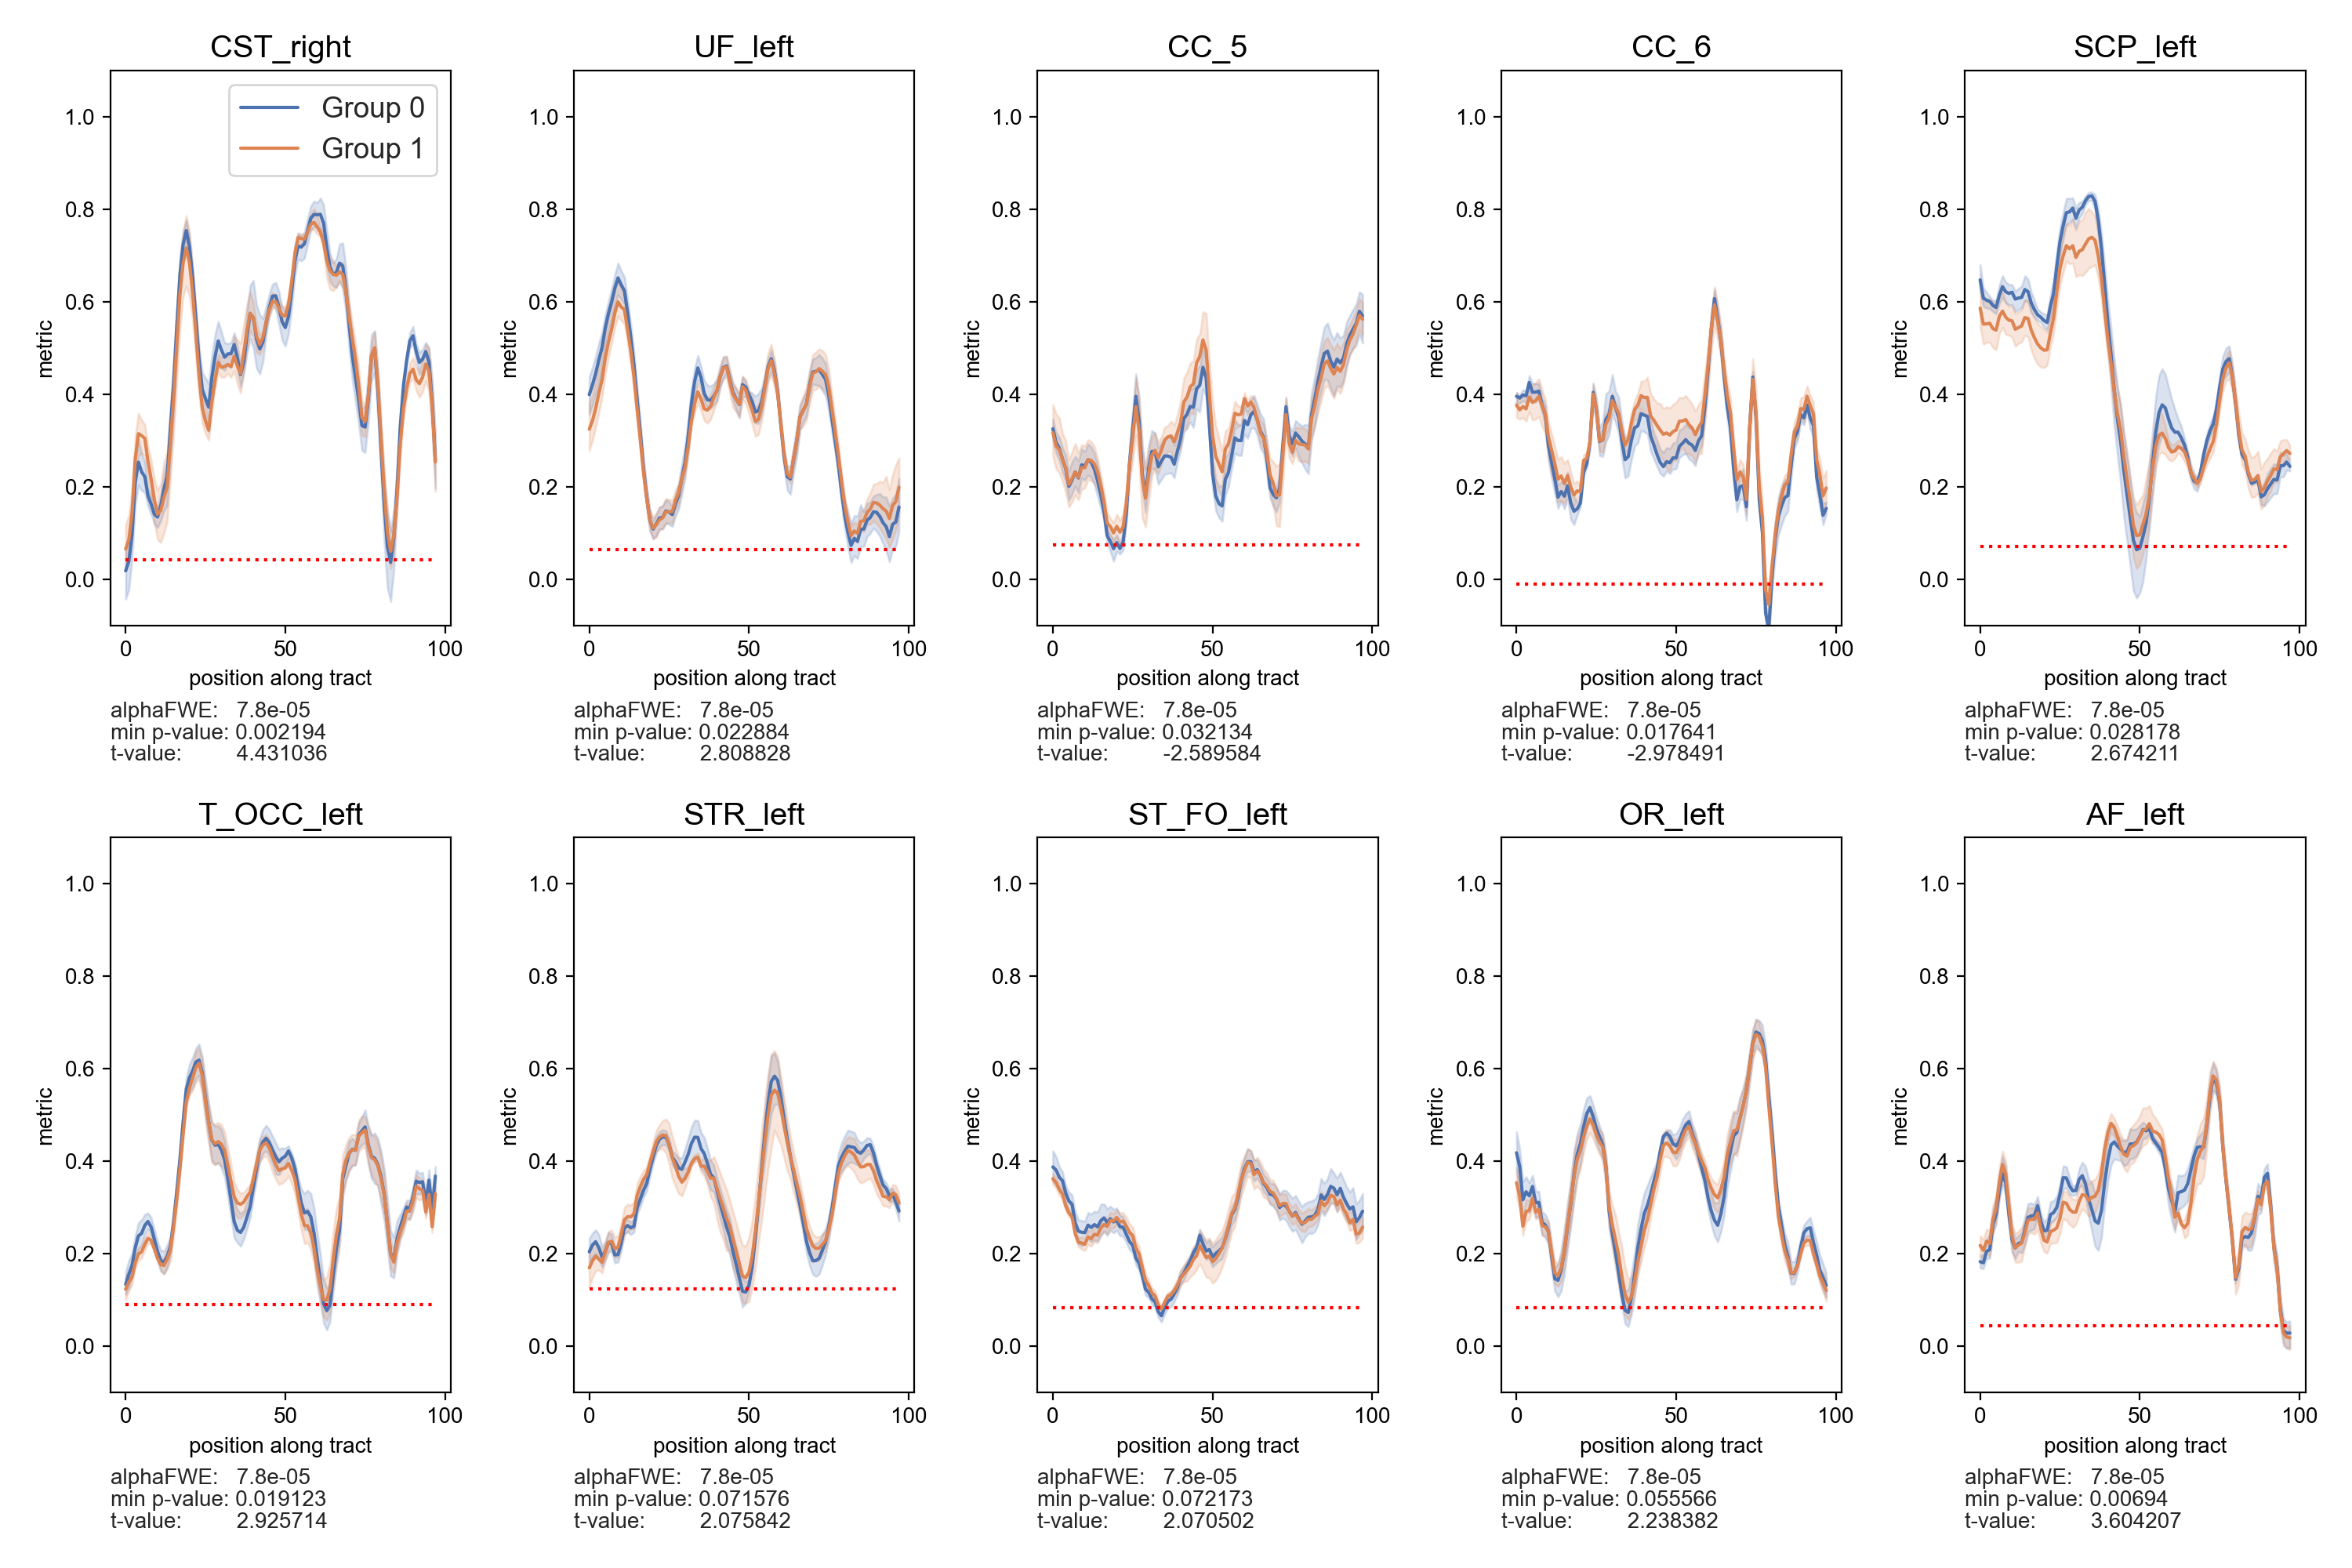

In [11]:
# View plot
Image(filename='/Users/dataprocessing/Documents/IAM/TractSeg/tractometry_result_FA.png') 

## Run for MK

In [10]:
failedRun = []
for i in subPaths:
    subID = op.basename(i)
    
    subOut = op.join(output, subID)
    ts.runtractseg_(input=i,
               output=subOut,
               template=path_mni,
               metric='mk',
               docker=None)
print('STAGE 3: Group analysis')
print('')
arg = ['plot_tractometry_results']
arg.extend(['-i', '/Users/dataprocessing/Documents/IAM/TractSeg/subjects_MK.txt'])
arg.extend(['-o', '/Users/dataprocessing/Documents/IAM/TractSeg/tractometry_result_mk.png'])
# arg.extend(['--plot3D', 'metric', '--tracking_format', 'trk'])
arg.append('--mc')
print('COMMAND: {}'.format(' '.join(arg)))
completion = subprocess.run(arg)
if completion.returncode != 0:
    raise Exception('Unable to run TractSeg: Group analysis. '
                    'Check above for errors')

Processing IAM_1158

----- Files being processed -----
Metric: /Users/dataprocessing/Documents/IAM/TractSeg_Subs_BAK/IAM_1158/metrics/mk.nii
---------------------------------

STAGE 1: Image registration into MNI space

Removing NaNs from scalar image
Transform metric into MNI space...
Thresholding scalar image
Running tracotometry...


Processing IAM_1160

----- Files being processed -----
Metric: /Users/dataprocessing/Documents/IAM/TractSeg_Subs_BAK/IAM_1160/metrics/mk.nii
---------------------------------

STAGE 1: Image registration into MNI space

Removing NaNs from scalar image
Transform metric into MNI space...
Thresholding scalar image
Running tracotometry...


Processing IAM_1156

----- Files being processed -----
Metric: /Users/dataprocessing/Documents/IAM/TractSeg_Subs_BAK/IAM_1156/metrics/mk.nii
---------------------------------

STAGE 1: Image registration into MNI space

Removing NaNs from scalar image
Transform metric into MNI space...
Thresholding scalar image
Running t

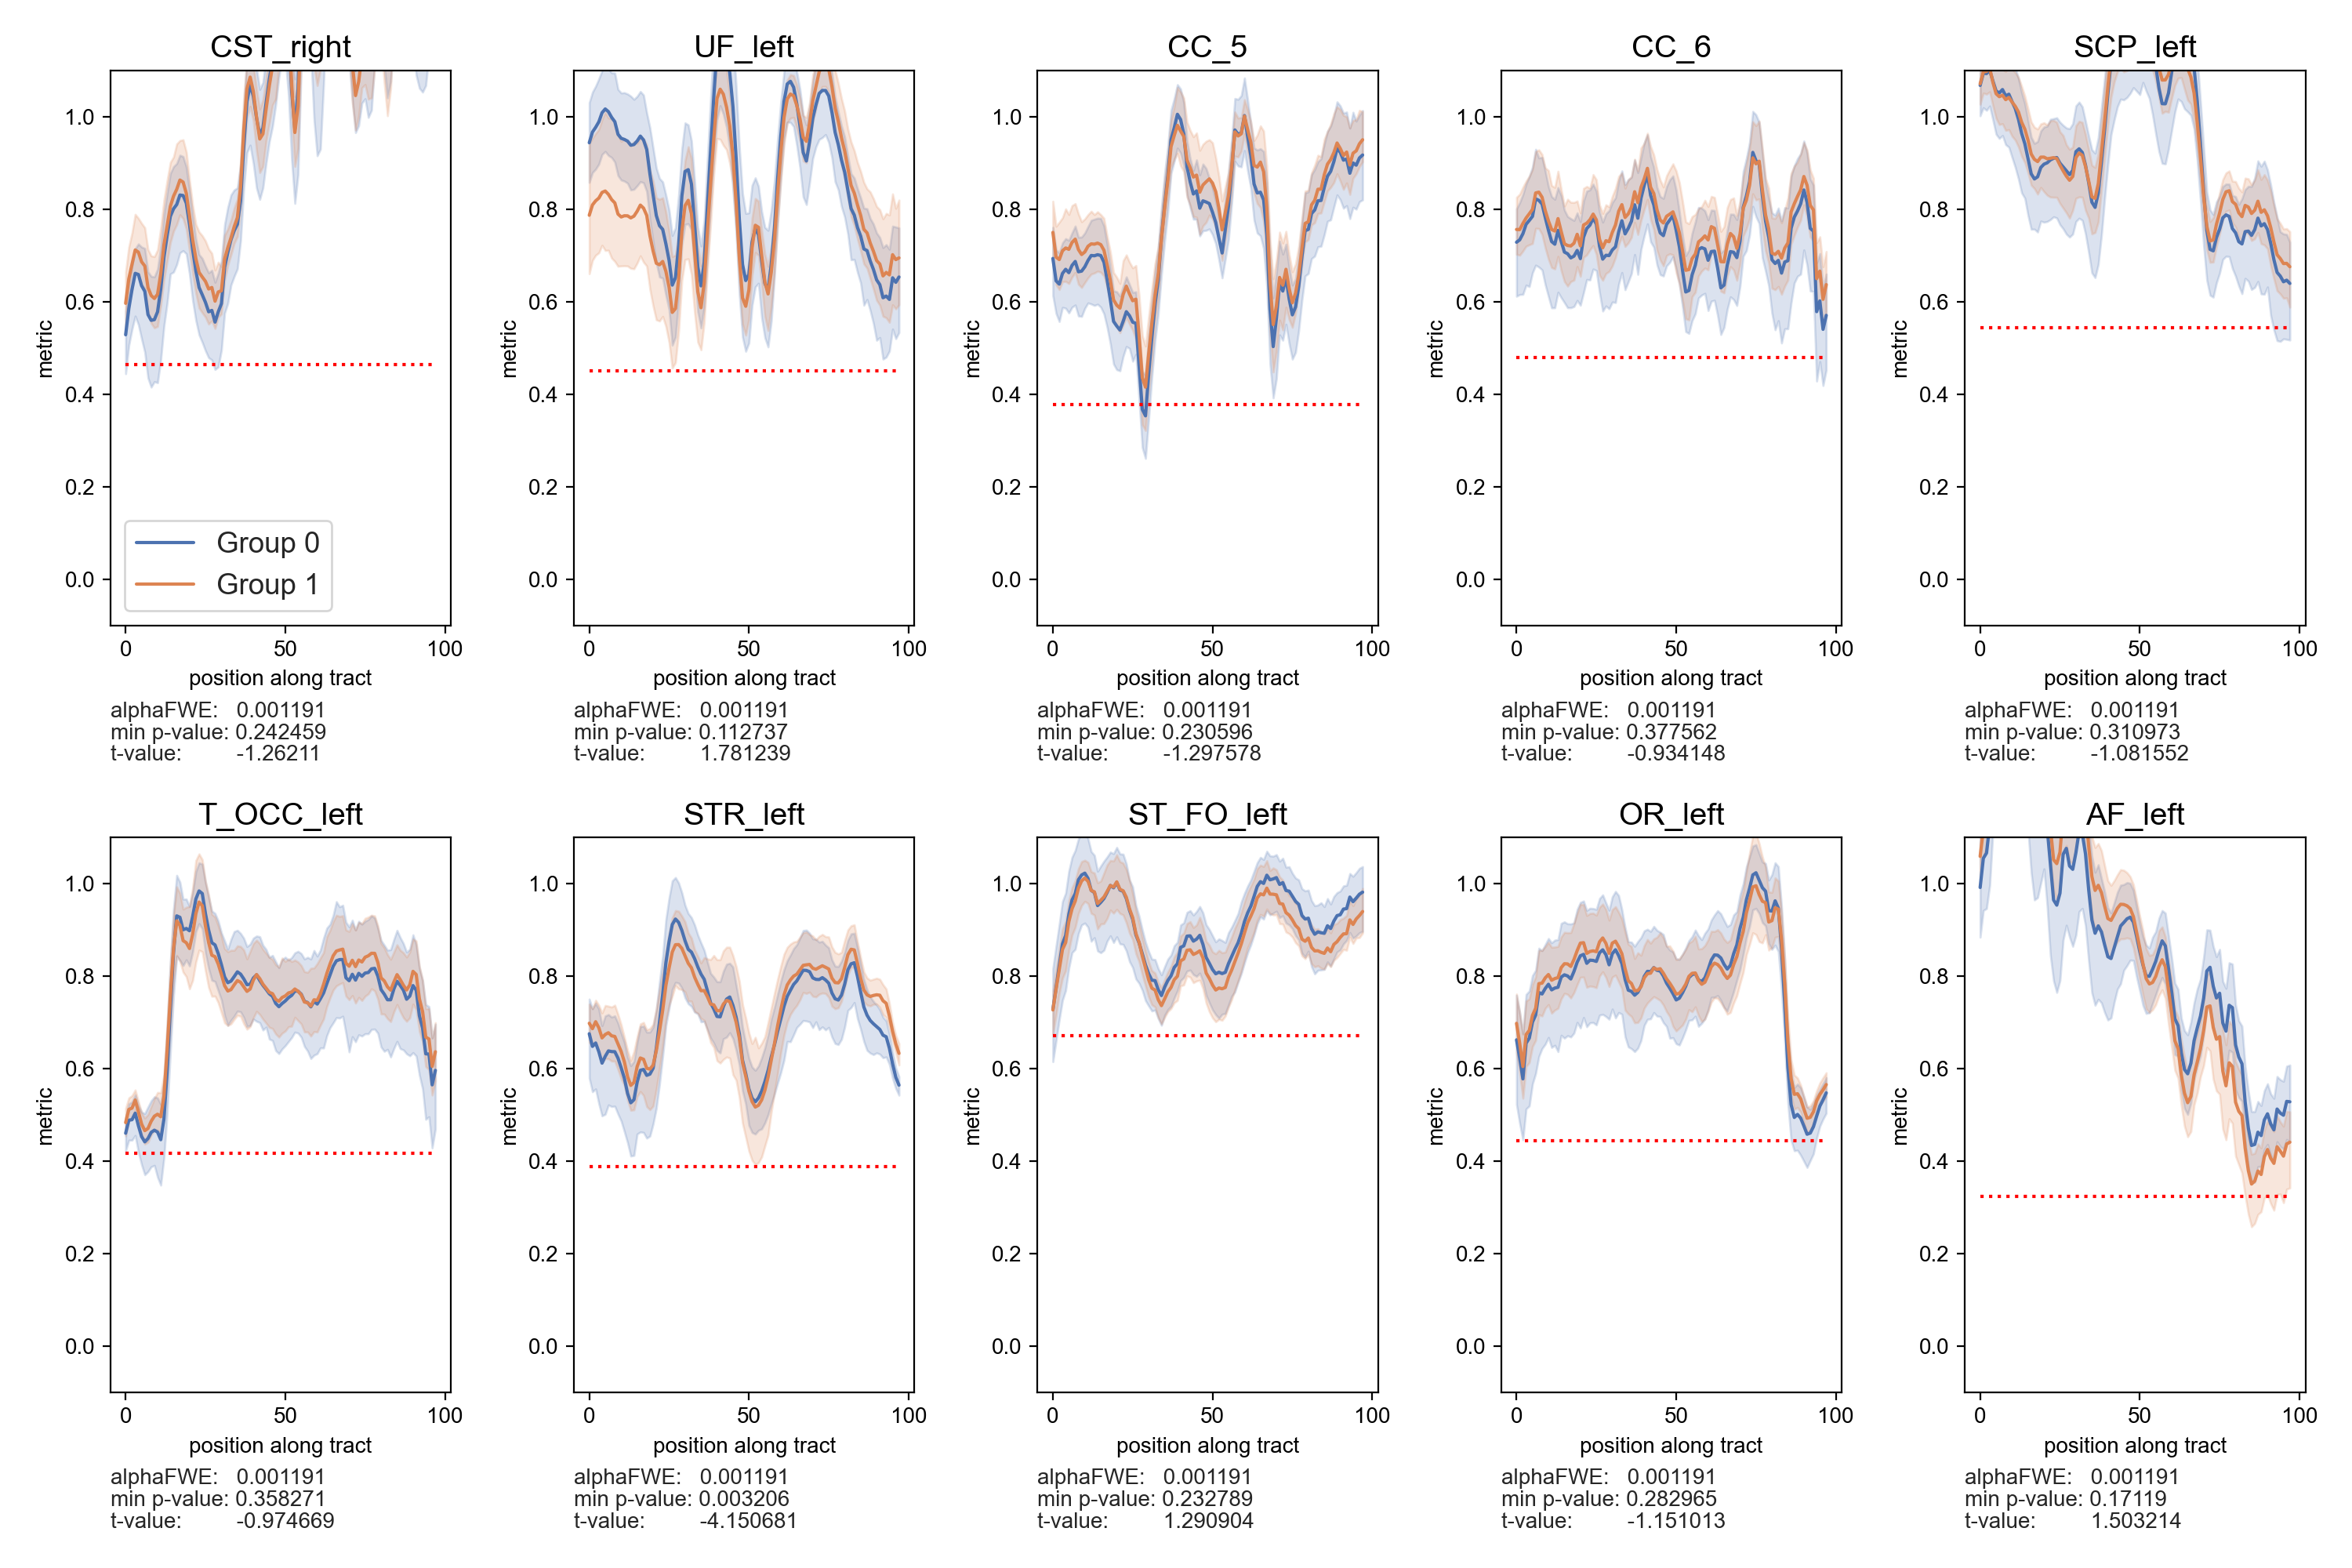

In [12]:
# View plot
Image(filename='/Users/dataprocessing/Documents/IAM/TractSeg/tractometry_result_mk.png') 